# Deep Learning Essentials

### Hyperparameter Tuning:
Create a model in Keras and configure based on following user-defined hyperparameters. The values assigned to each hyperparameter may effect the model performance and here we show how to optimize each one of them. 
1. HiddenLayers
2. HiddenActivation
3. OutputNodes
4. OutputActivation
5. WeightInitializer
6. BiasInitializer
7. Normalization
8. Optimizer
9. LearningRate
10. Regularizer
11. DropoutRate
12. Epochs
13. BatchSize
14. TestDataSize
15. LossFunction
16. Metrics

#### Preprocessing
Data preparation:

1. Load data into a pandas dataframe
2. Scale the feature dataset
3. Split into training and test datasets

In [1]:
# Import necessary libraries:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import datasets, preprocessing
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Retrieve one of the built-in data set in scikit-learn library:
iris_dict = datasets.load_iris() # Returns a dictionary

# Put the data in a DataFrame:
iris_df = pd.DataFrame(data = iris_dict.data, columns = iris_dict.feature_names)
iris_df['target'] = iris_dict['target']

In [3]:
# Check out the data:
# Features: 4 baseline variables, sepal length (cm), sepal width (cm), petal length (cm), petal width (cm).
# Target: 3 plant classes: Setosa, Versicolour, Virginica.
# Details on data set is available here: https://scikit-learn.org/stable/datasets
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# Split the features and target labels as X and Y data:
X = iris_df.drop('target', axis = 1)
y = iris_df['target']

In [5]:
# Scale the data:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#Categorize the target data:
y = pd.get_dummies(y)
y = y.astype(int)

#### Create and Configure Deep Neural Network Model:

In [6]:
# Model configuration dictionary with some initial values:
def default_config():
    model_config = {
        "HiddenLayers" : [16,32,16],
        "HiddenActivation" : "relu",
        "OutputNodes" : 3,                                 # 3 classes to predict
        "OutputActivation" : "softmax",
        "WeightInitializer" : "random_normal",
        "BiasInitializer" : "zeros",
        "Normalization" : "none",
        "Optimizer" : "rmsprop",
        "LearningRate" : 0.001,
        "Regularizer" : None,
        "DropoutRate" : 0.0,
        "Epochs" : 10,
        "BatchSize" : 8,
        "TestDataSize" : 0.2,
        "ValidationSplit": 0.2,
        "Verbose" : 0,
        "LossFunction" : "categorical_crossentropy",
        "Metrics" : ["accuracy"]
        }
    return model_config

In [23]:
def generate_and_run_model(model_config, X, y): # Generates a deep neural network model based on the user-defined configurations and run it.
    model = tf.keras.models.Sequential()
    
    # Add the input layer:
    model.add(tf.keras.layers.Input(shape=(X.shape[1],)))

    # Add the hidden layers:
    for layer in range(len(model_config["HiddenLayers"])):

        model.add(tf.keras.layers.Dense(model_config["HiddenLayers"][layer],
                                        name="HiddenLayer-" + str(layer),
                                        activation=model_config["HiddenActivation"],
                                        kernel_initializer=model_config["WeightInitializer"],
                                        kernel_regularizer=model_config["Regularizer"],
                                        bias_initializer=model_config["BiasInitializer"]
                                        ))
            
        if model_config["Normalization"] == "batch":
            model.add(tf.keras.layers.BatchNormalization())            
    
        if model_config["DropoutRate"] > 0.0:
            model.add(tf.keras.layers.Dropout(model_config["DropoutRate"]))            

    # Add the output layer:        
    model.add(tf.keras.layers.Dense(model_config["OutputNodes"],
                                    name="OutputLayer",
                                    activation=model_config["OutputActivation"])
                                    )
    
    # Set the optimizer:
    optimizer_name = model_config["Optimizer"]
    learning_rate = model_config["LearningRate"]

    if optimizer_name == 'adagrad': 
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=model_config["LossFunction"],
                  metrics=model_config["Metrics"]
                  )
    
    #model.summary()

    # Split the dataset into training and testing data. 20% of the data is kept as testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=model_config["TestDataSize"],
                                                        stratify=y
                                                        )

    # Run the model:
    history = model.fit(X_train, y_train,
                        batch_size=model_config["BatchSize"],
                        epochs=model_config["Epochs"],
                        verbose=model_config["Verbose"],
                        validation_split=model_config["ValidationSplit"]
                        )
    return history


In [19]:
def plot_performance(model_performances):

    fig = plt.figure(figsize=(10, 6))
    for model in model_performances.keys():
        plt.plot(model_performances[model], '--o', label=model, linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.ylim([0, 1])
    plt.show()

### Evaluate Each Hyperparameter: 

### 1. Effect of Batch Size:

In [9]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models for batch size from 0 to 128 increasing by 16. 
for batch_size in range(0,48,8):
    
    # Set batch size:
    model_config["BatchSize"] = batch_size
    
    model_name = "DNN - BatchSize - " + str(batch_size)
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

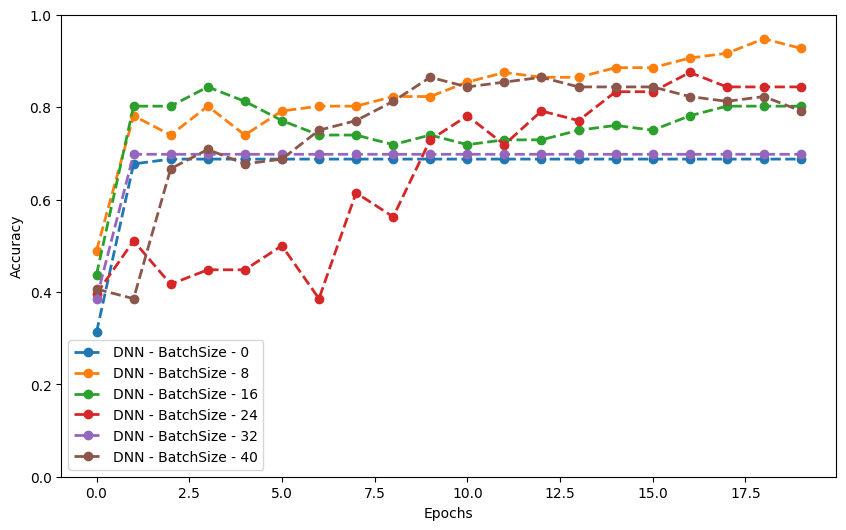

In [10]:
plot_performance(model_performances)

### 2. Effect of # of Nodes in a Layer:

In [11]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models for number of nodes ranging from 8 to 64 increasing by 8 (Assume we have two hidden layers with the same number of nodes): 
for num_nodes in range(8,64,8):
    
    # 2 hidden layers in the models:
    hidden_nodes = []
    for num_layers in range(2):
        hidden_nodes.append(num_nodes)

    # Set number of nodes in hidden layers:
    model_config["HiddenLayers"] = hidden_nodes
    
    model_name = "DNN - HiddenLayers - [" + str(num_nodes) + ", " + str(num_nodes) + "]"
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

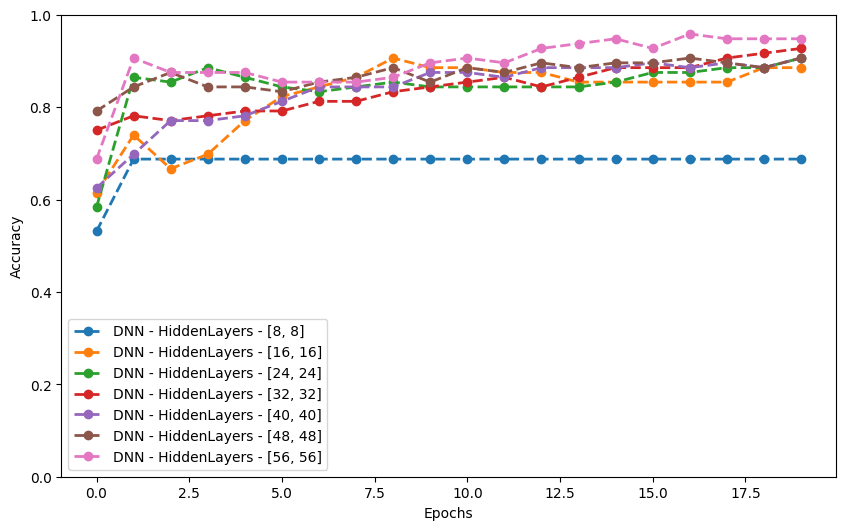

In [12]:
plot_performance(model_performances)

### 3. Effect of # of Hidden Layers:

In [16]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models for number of hidden layers ranging from 0 to 5 increasing by 1 (Assume we have the same number of nodes in each layers):
layers =[] 
for num_layers in range(1,6):
    
    # 16 nodes in each layer
    layers.append(16)
    
    # Set hidden layers:
    model_config["HiddenLayers"] = layers
    
    model_name = "DNN - HiddenLayers - " + str(layers)
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

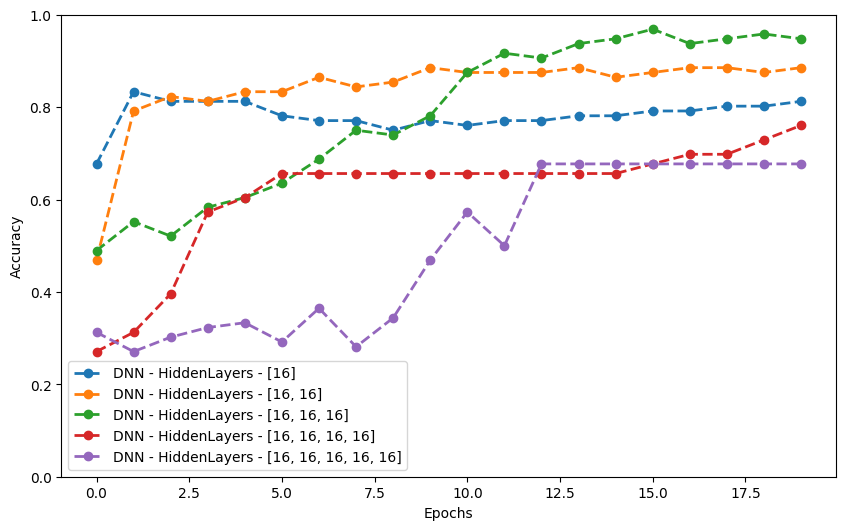

In [17]:
plot_performance(model_performances)

### 4. Effect of Activation Functions:

In [18]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models for different activation functions in each hidden layer:
activation_functions = ['relu','sigmoid','tanh', 'linear']
for activation in activation_functions:
    
    # Set hidden layer activation function:
    model_config["HiddenActivation"] = activation
    
    model_name = "DNN - HiddenActivation - " + activation
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

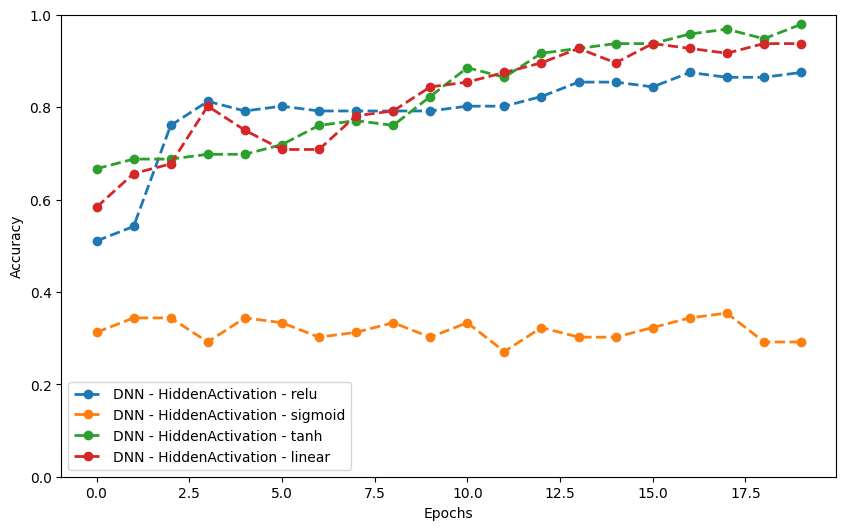

In [20]:
plot_performance(model_performances)

### 5. Effect of Optimizers:

In [24]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models for different optimizer:
optimizers = ['sgd','rmsprop','adam','adagrad']
for optim in optimizers:
    
    # Set the optimizer:
    model_config["Optimizer"] = optim
    
    model_name = "DNN - Optimizer - " + optim
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

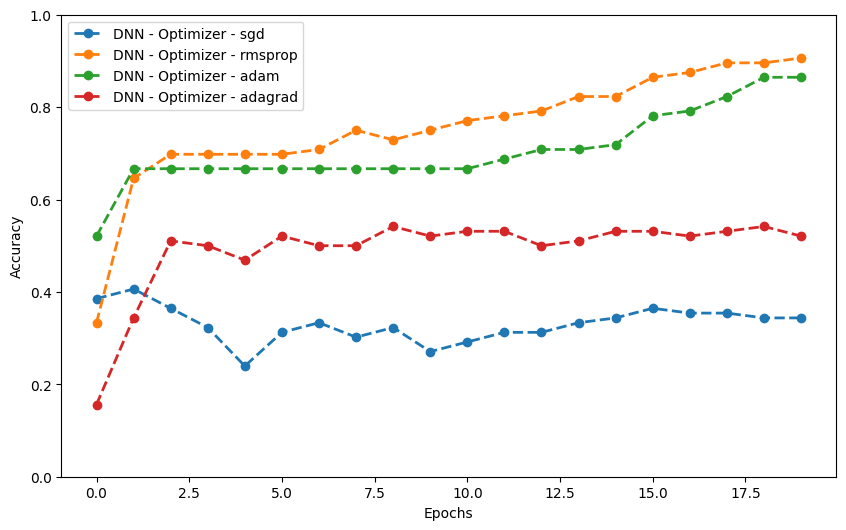

In [25]:
plot_performance(model_performances)

### 6. Effect of Batch Normalization:

In [26]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models by including an excluding normalization:
normalization = ['none','batch']
for norm in normalization:
    
    # Set the normalization:
    model_config["Normalization"] = norm
    
    model_name = "DNN - BatchNormalization - " + norm
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

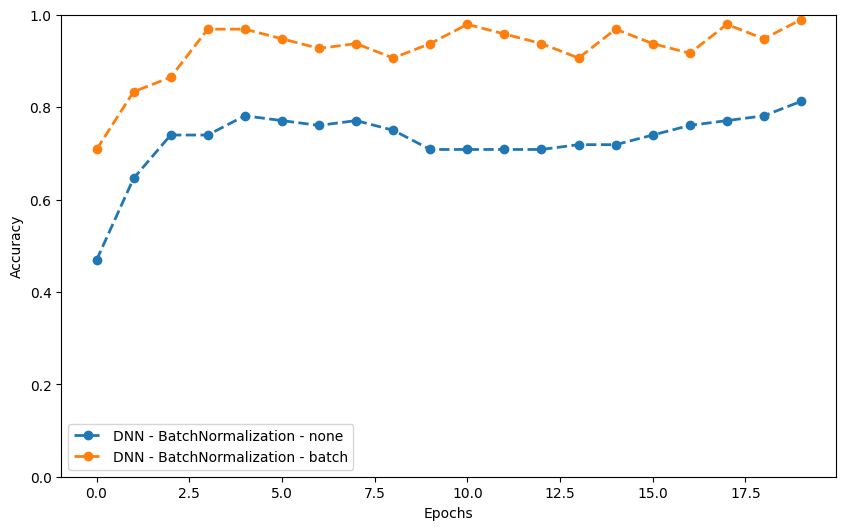

In [27]:
plot_performance(model_performances)

### 7. Effect of Learning Rate:

In [28]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models for different learning rates:
LR_default = model_config["LearningRate"]
learning_rates = [LR_default, 2*LR_default, 5*LR_default, 10*LR_default, 100*LR_default]
for lr in learning_rates:
    
    # Set the learning rate:
    model_config["LearningRate"] = lr
    
    model_name = "DNN - LearningRate - " + str(lr)
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

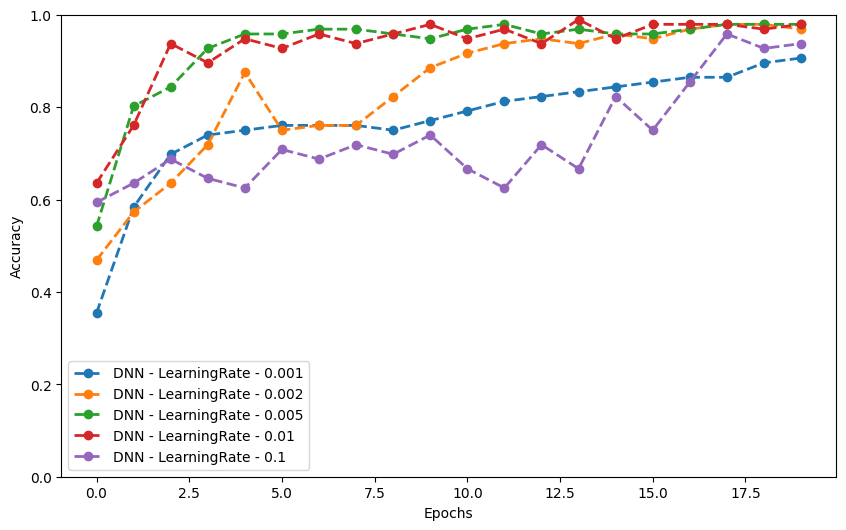

In [29]:
plot_performance(model_performances)

### 8. Effect of Dropout Rates:

In [31]:
model_performances = {}

# Load default configuration
model_config = default_config()
    
# Fix the Epoch to 20:
model_config["Epochs"]=20

# Generate and run models for different dropout rates:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
for dr in dropout_rates:
    
    # Set the dropout rate:
    model_config["DropoutRate"] = dr
    
    model_name = "DNN - DropoutRate - " + str(dr)
    history = generate_and_run_model(model_config,X,y)
    
    model_performances[model_name] = history.history["accuracy"]

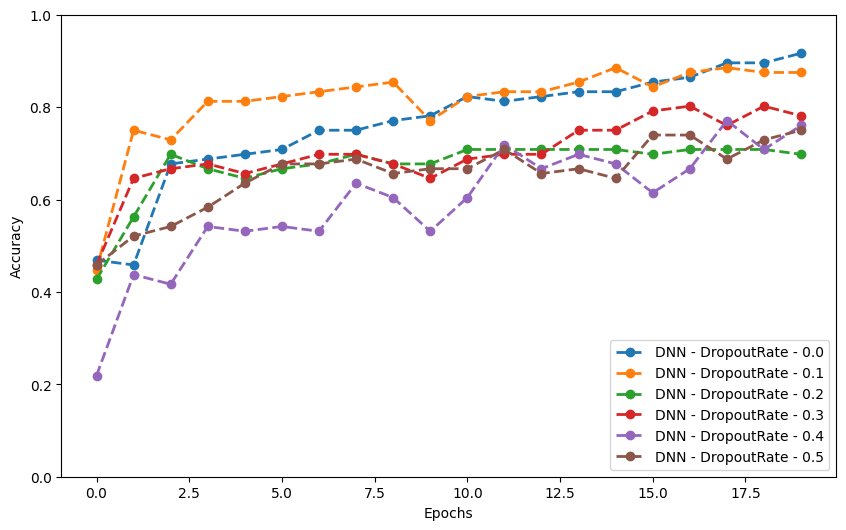

In [32]:
plot_performance(model_performances)